In [1]:
import pandas as pd

In [2]:
def get_lps(s):
    t = s.split('_')
    return f'{t[3].upper()}_{t[2]}'

def get_array(s):
    t = s.split('_')
    return f'{t[2]}'
    

In [3]:
def process_perbin(path, array = None):
    df = pd.read_csv(path, header = None, sep = '\t')
    df.columns = ["file", "(0–0.01]", "(0.01–0.05]", "(0.05–0.5]", "(0.01–0.5]"]
    #df = df.iloc[:, :-1]
    df = pd.melt(df, id_vars=['file'], var_name='bins')
    
    if array:
        df['file'] = df['file'].replace(regex={
            'Axiom_PMRA': 'PMRA',
            'Axiom_JAPONICA': 'JAPONICA',
            'infinium-omni2.5.v1.5': 'OMNI2.5',
            'cytosnp-850k-v1.2': 'CYTOSNP',
            'global-screening-array-v.3': 'GSA',
            'infinium-omni5-v1.2': 'OMNI5',
            'Axiom_PMDA': 'PMDA',
            'Axiom_UKB_WCSG': 'UKB-WCSG'
        })
        #print(df)
        df['array'] = [get_array(i) for i in df['file']]
        df['pop'] = [i.split('_')[3] for i in df['file']]
        df['array'] = df['array'].replace(regex={
            'UKB-WCSG': 'UKB_WCSG'
        })
        df['type'] = 'array'
    else:
        df['array'] = [get_lps(i) for i in df['file']]
        df['pop'] = [i.split('_')[4] for i in df['file']]
        df['type'] = 'lps'
    
    return df 
    

In [4]:
# lps_res = process_perbin('data/raw_snpwise_accuracy/lps_all_cov.txt')

# array_res = process_perbin('data/raw_snpwise_accuracy/array_all_cov.txt', array=True)

In [5]:
lps_res = process_perbin('data/raw_snpwise_accuracy/lps_all_acc.txt')

array_res = process_perbin('data/raw_snpwise_accuracy/array_all_acc.txt', array=True)

In [6]:
data = pd.concat([lps_res, array_res])

In [7]:
# ## to not edit codes
# data.columns = ['file', 'trait', 'pct_dif', 'array', 'pop']

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def do_filter_data(data, bins, pop):
    pick = (data['bins'] == bins) & (data['pop'] == pop)
    return data[pick]

In [10]:
#sorted(data.array.unique())

In [11]:
desired_order = ['GSA', 
                'JAPONICA',
                'UKB_WCSG',
                'CYTOSNP', 
                'PMRA', 
                'PMDA',
                'OMNI2.5', 
                'OMNI5',
                'LPS_0.5',
                'LPS_0.75',
                'LPS_1.0',
                'LPS_1.25',
                'LPS_1.5',
                'LPS_2.0'] 

In [12]:
def plot_1(data, bins, pop, axe):

    filterd_data = do_filter_data(data, bins, pop)
    #print(filterd_data.shape)
    sns.boxplot(data=filterd_data, 
                y = 'array', 
                x = 'value', 
                hue='type', fill=False,
                width=0.4,
                order=desired_order,
                fliersize= 0.5,
                orient='h',
                ax=axe)
    threshold = filterd_data[filterd_data['array'] == 'GSA']['value'].median()
    #print(threshold)
    axe.axvline(threshold, 0, 10, c='r', linestyle ="--", linewidth = 1)
    axe.grid(axis='both', linewidth=0.5)
    axe.legend().set_visible(False)

In [13]:
#plot_1(data, bins = , pop, axe)

In [14]:
#plot_1(data, y, x, axes[i,j])

In [15]:

def full_plot(data):
    cols = data['bins'].unique()
    rows = data['pop'].unique()
    fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), figsize=(11,13))

    for i, x in enumerate(rows):
        for j, y in enumerate(cols):
            plot_1(data, y, x, axes[i,j])
            
            # Ticks
            axes[i,j].set_xlim(0, 1.01)
            axes[i,j].set_xticks(np.arange(0, 1.01, 0.2))
            axes[i,j].set_ylabel("")
            axes[i,j].set_xlabel("")
            
            if j != 0:
                pass
                #axes[i,j].set_yticks([])
                
            if i == 0:
                # Title
                axes[i,j].set_title(label=y, 
                            color='white', 
                            bbox=dict(facecolor='#b3b3b3', edgecolor='white', boxstyle='round,pad=0.6'), 
                            x=0.5, pad=12,
                            fontdict={'fontsize':10})
            if j == 0:
                axes[i,j].set_ylabel(ylabel=x,
                                                color='white',
                                                labelpad = 12,
                                                rotation = 'horizontal', 
                                                bbox=dict(facecolor='#b3b3b3', 
                                                          edgecolor='white', 
                                                          boxstyle='round,pad=0.6'),
                                                fontdict={'fontsize':10})
            
    for line_num, line_axis in enumerate(axes):
        for col_num, ax in enumerate(line_axis):
            if col_num == 0:
                continue
            ax.set_ylim(line_axis[0].get_ylim()) # align axes
            plt.setp(ax.get_yticklabels(), visible=False)
                
    
    fig.tight_layout(rect=[0.02, 0.02, 1, 1])
    #axes.flatten()[0].legend(bbox_to_anchor=(5, 1), fontsize=12)
    plt.savefig(f'out_figs/acc.pdf', dpi=300)


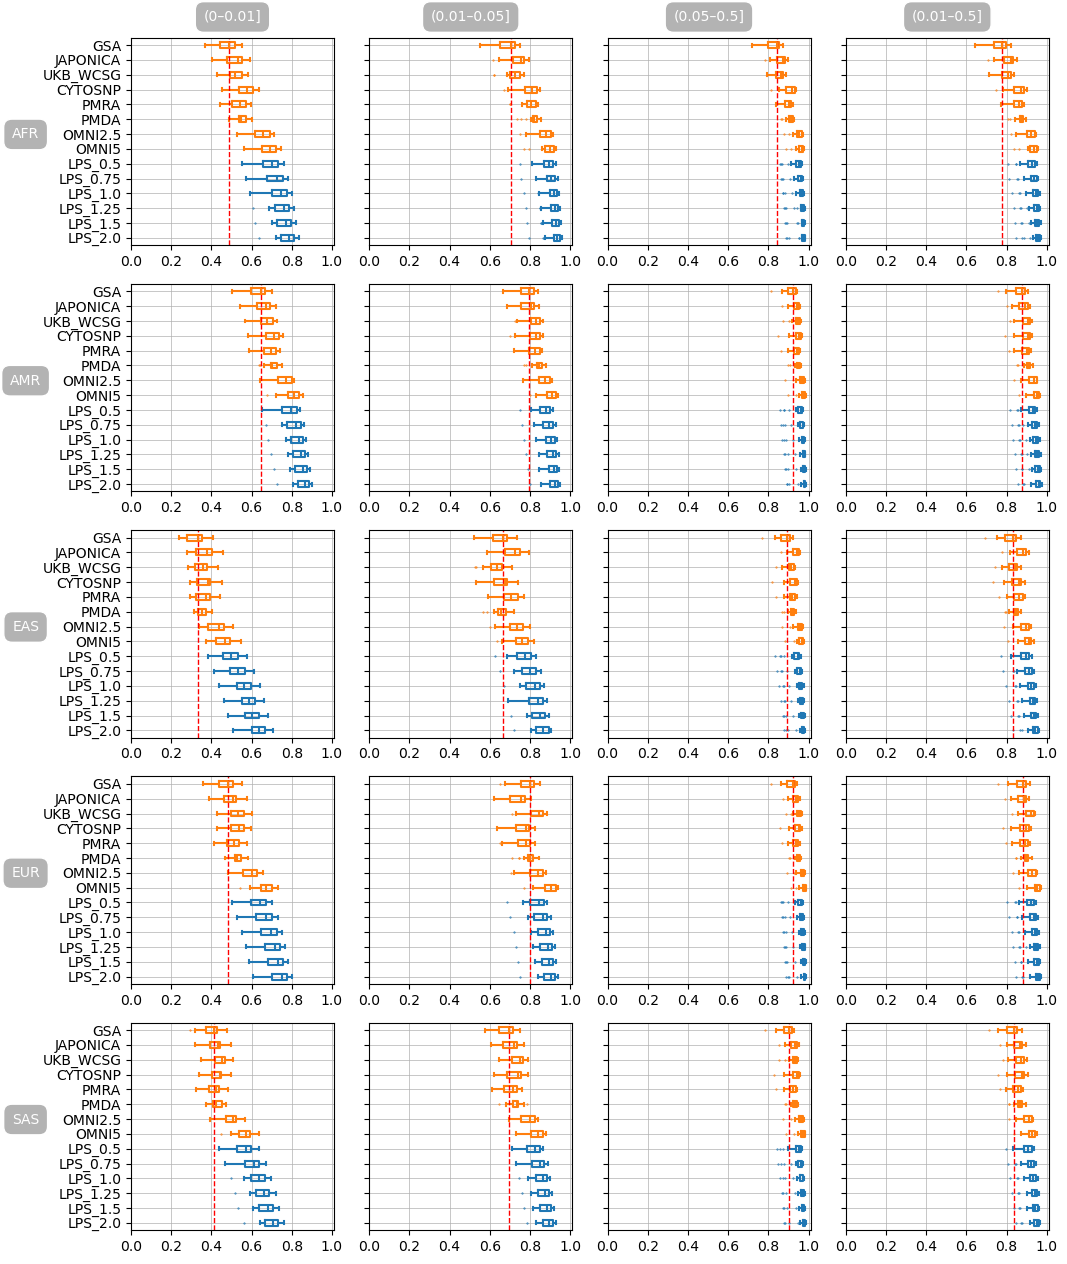

In [16]:
full_plot(data)

In [17]:
#data.to_csv('r2_acc_plot_data.csv', index = False)

In [18]:
df = data
# Compute mean ± sd
summary = df.groupby(["type", "bins", "array", "pop"]).agg(
    mean=("value", "mean"),
    std=("value", "std")
).reset_index()

# Format output
summary["formatted"] = summary.apply(lambda x: f"{x['mean']:.3f} ± {x['std']:.3f}", axis=1)

# Pivot to table format
result = summary.pivot(index=["bins", "array"], columns="pop", values="formatted").reset_index()

# Sort by provided order
result["array"] = pd.Categorical(result["array"], categories=desired_order, ordered=True)
result = result.sort_values(["bins", "array"])

# Write separate CSV for each bin
for bin_val, df_bin in result.groupby("bins"):
    df_bin = df_bin.drop(columns=["bins"])
    df_bin = df_bin.rename(columns={'array': 'Array/LPS'})
    df_bin.to_csv(f"out_tables/mean_r2_summary_bin_{bin_val}.csv", index=False)

In [1]:
#t = result.groupby("bins")

In [2]:
#result.to_csv('acc_all.csv', index=False)